In [277]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Config

#path to file generated by other script will take more than one data set
DATA_FILES = [r"./data/synthetic_data_independent_failures_5.csv", "./data/synthetic_data_independent_failures_4.csv"]

SEQUENCE_LENGTH = 24 * 7
STEP_SIZE = 24 * 2
FORECAST_HORIZON = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [278]:
# Data processing 
def load_and_combine_data(file_paths):
    """
    Loads multiple CSV files, finds the union of all sensor features, 
    reindexes dataframes to match the full feature set (filling missing sensors with 0.0), 
    and concatenates them into a single DataFrame.
    """
    all_data = []
    all_sensor_features = set()
    
    # Load data and collect all unique sensor feature names
    non_sensor_cols = ['machine_id', "timestamp",'failure_mode', 'is_precursor_period', 'is_final_failure']
    
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            
            # Identify potential sensor features in the current file
            current_sensor_features = [col for col in df.columns if col not in non_sensor_cols]
            print(current_sensor_features)
            all_sensor_features.update(current_sensor_features)
            
            all_data.append(df)
            print(f"Loaded {file_path} with {len(current_sensor_features)} sensor features.")
        except FileNotFoundError:
            print(f"Warning: File '{file_path}' not found. Skipping.")
    
    if not all_data:
        raise FileNotFoundError("No valid data files were loaded.")

    
    sensor_feature_list = sorted(list(all_sensor_features))
    final_combined_df = pd.DataFrame()
    full_column_list = non_sensor_cols + sensor_feature_list
    
    for df in all_data:
        
        df_reindexed = df.reindex(columns=full_column_list, fill_value=0.0)
        
        final_combined_df = pd.concat([final_combined_df, df_reindexed], ignore_index=True)

    print(f"\nSuccessfully combined {len(all_data)} files.")
    print(f"Total rows in combined data: {len(final_combined_df)}")
    print(f"Total unique sensor features used: {len(sensor_feature_list)}")
    
    return final_combined_df, sensor_feature_list

In [279]:
try:
    data, sensor_features = load_and_combine_data(DATA_FILES)
except FileNotFoundError as e:
    print(f"Fatal Error: {e}")

['T_internal_sensor', 'V_sensor']
Loaded ./data/synthetic_data_independent_failures_5.csv with 2 sensor features.
['T_internal_sensor', 'V_sensor']
Loaded ./data/synthetic_data_independent_failures_4.csv with 2 sensor features.

Successfully combined 2 files.
Total rows in combined data: 236520
Total unique sensor features used: 2


In [280]:
def create_sequences(data, seq_length, forecast_horizon, step_size):
    sequences = []
    target = []
    for i in range(0, len(data) - seq_length - forecast_horizon + 1, step_size):
        sequences.append(data[i:i+seq_length])
        target.append(data[i+seq_length: i+seq_length+forecast_horizon])
    return np.array(sequences), np.array(target)

In [281]:
def prepare_data(df, sensor_features):
    """Loads, cleans, labels, and scales the data. Returns sequences and the fitted scaler."""
    sensor_data = df[sensor_features].values
   
    # 2. Standardization
    scaler = StandardScaler()
    sensor_data_scaled = scaler.fit_transform(sensor_data)
    
    # 3. Create Sequences
    X_seq, Y_seq = create_sequences(sensor_data_scaled, SEQUENCE_LENGTH, FORECAST_HORIZON, STEP_SIZE)
    
    print(f"\n--- Data Preparation Complete ---")
    print(f"Total time points in raw data: {len(df)}")
    print(f"Total sequences created: {len(X_seq)}")
    print(f"Sequence shape (num_samples, time steps, features): {X_seq.shape}")
    
    # Return the fitted scaler so we can inverse-transform predictions later
    return X_seq, Y_seq, scaler

In [282]:
X_seq, Y_seq, scaler = prepare_data(data, sensor_features)

# Split data into training, validation, and testing sets for 3D arrays
# First split: 80% train+val, 20% test
indices = np.arange(X_seq.shape[0])
train_val_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=False)

# Second split: 75% train, 25% val (of the train+val set = 60% train, 20% val overall)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.25, random_state=42, shuffle=False)

X_train, X_val, X_test = X_seq[train_indices], X_seq[val_indices], X_seq[test_indices]
Y_train, Y_val, Y_test = Y_seq[train_indices], Y_seq[val_indices], Y_seq[test_indices]



--- Data Preparation Complete ---
Total time points in raw data: 236520
Total sequences created: 4924
Sequence shape (num_samples, time steps, features): (4924, 168, 2)


In [283]:
# TensorFlow/Keras doesn't need a custom Dataset class
# Data will be prepared directly as numpy arrays

In [284]:
X_train.shape, Y_train.shape

((2954, 168, 2), (2954, 1, 2))

In [285]:
# Prepare data for each sensor feature
# TensorFlow expects data in shape (samples, timesteps, features)
print(f"\nPreparing data for {X_train.shape[2]} sensor features...")
print(f"Data shapes: X_train={X_train.shape}, Y_train={Y_train.shape}")


Preparing data for 2 sensor features...
Data shapes: X_train=(2954, 168, 2), Y_train=(2954, 1, 2)


In [286]:
def create_cnn_model(seq_length, forecast_horizon):
    """
    Simple 1D CNN for time-series regression built with TensorFlow/Keras.
    Architecture: Conv1D -> MaxPool -> Dense -> Output
    """
    model = models.Sequential([
        layers.Input(shape=(seq_length, 1)),
        layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='valid'),
        layers.Dropout(0.25),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(forecast_horizon)
    ])
    
    return model

In [287]:
# --- 3. TRAINING AND EVALUATION ---
def prepare_feature_data(X, Y, feature_idx):
    """Extract data for a specific feature index."""
    X_feature = X[:, :, feature_idx:feature_idx+1]
    Y_feature = Y[:, :, feature_idx].squeeze()
    return X_feature, Y_feature


In [288]:
def evaluate_model(model, X_test, Y_test):
    """TensorFlow/Keras evaluation."""
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    y_true = Y_test
    
    return y_true, y_pred

def calculate_msre(y_pred, y_true):
    avg_error_per_column = np.mean(np.abs(y_true - y_pred), axis=0)
    print(f"Average error per column: {avg_error_per_column}")
    mse = np.mean((y_true - y_pred) ** 2)
    print(f"Total MSE: {mse}")
    return np.sqrt(mse)

In [289]:
select_model = 0

In [290]:
# Build the TensorFlow/Keras CNN model
model = create_cnn_model(X_train.shape[1], FORECAST_HORIZON)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()
print("\nModel Architecture:")

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 164, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 164, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 82, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 5248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50)             │       262,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,885 (1.00 MB)

 Trainable params: 262,885 (1.00 MB)

 Non-trainable params: 0 (0.00 B)


Model Architecture:


In [291]:
# Prepare data for the selected feature
X_train_feature, Y_train_feature = prepare_feature_data(X_train, Y_train, select_model)
X_val_feature, Y_val_feature = prepare_feature_data(X_val, Y_val, select_model)
X_test_feature, Y_test_feature = prepare_feature_data(X_test, Y_test, select_model)

print(f"Training feature {select_model}: {sensor_features[select_model]}")
print(f"X_train_feature shape: {X_train_feature.shape}")
print(f"Y_train_feature shape: {Y_train_feature.shape}")

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    X_train_feature,
    Y_train_feature,
    validation_data=(X_val_feature, Y_val_feature),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Training feature 0: T_internal_sensor
X_train_feature shape: (2954, 168, 1)
Y_train_feature shape: (2954,)
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0469 - mae: 0.1680 - val_loss: 0.0398 - val_mae: 0.1530 - learning_rate: 0.0010
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0395 - mae: 0.1522 - val_loss: 0.0316 - val_mae: 0.1334 - learning_rate: 0.0010
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0359 - mae: 0.1477 - val_loss: 0.0395 - val_mae: 0.1530 - learning_rate: 0.0010
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0376 - mae: 0.1514 - val_loss: 0.0410 - val_mae: 0.1540 - learning_rate: 0.0010
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0350 - mae: 0.1476 - val_loss: 0.0363 - val_mae: 0.1384 - learning_rate: 0.0010
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0320 - mae: 0.1417 - val_loss: 0.0377 - val_mae: 0.1367 - learning_rate: 5.0000e-04
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

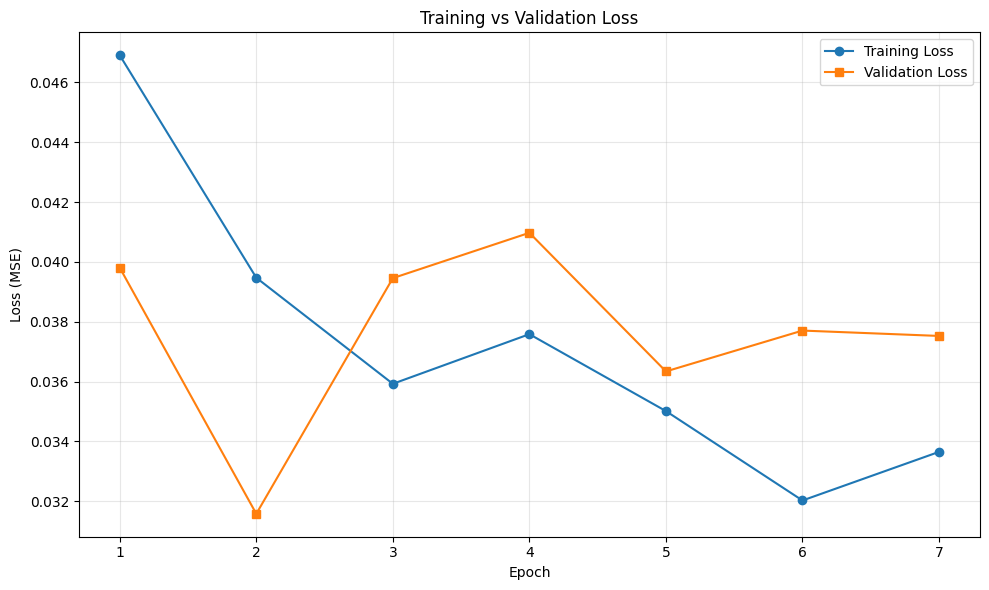


Final Training Loss: 0.0337
Final Validation Loss: 0.0375
Difference (Val - Train): 0.0039
Ratio (Val / Train): 1.12


In [292]:
# Plot training and validation loss
import matplotlib.pyplot as plt

train_losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
loss_diff = final_val_loss - final_train_loss
loss_ratio = final_val_loss / final_train_loss

print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"Difference (Val - Train): {loss_diff:.4f}")
print(f"Ratio (Val / Train): {loss_ratio:.2f}")

In [293]:
# Evaluate the model
print("\n--- Evaluating Model Performance ---")
y_true, y_pred = evaluate_model(model, X_test_feature, Y_test_feature)

# Regression metrics
mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_true.flatten(), y_pred.flatten())

print("\nRegression Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


--- Evaluating Model Performance ---

Regression Metrics:
Mean Squared Error (MSE): 0.0289
Root Mean Squared Error (RMSE): 0.1701
Mean Absolute Error (MAE): 0.1346
R² Score: 0.8702


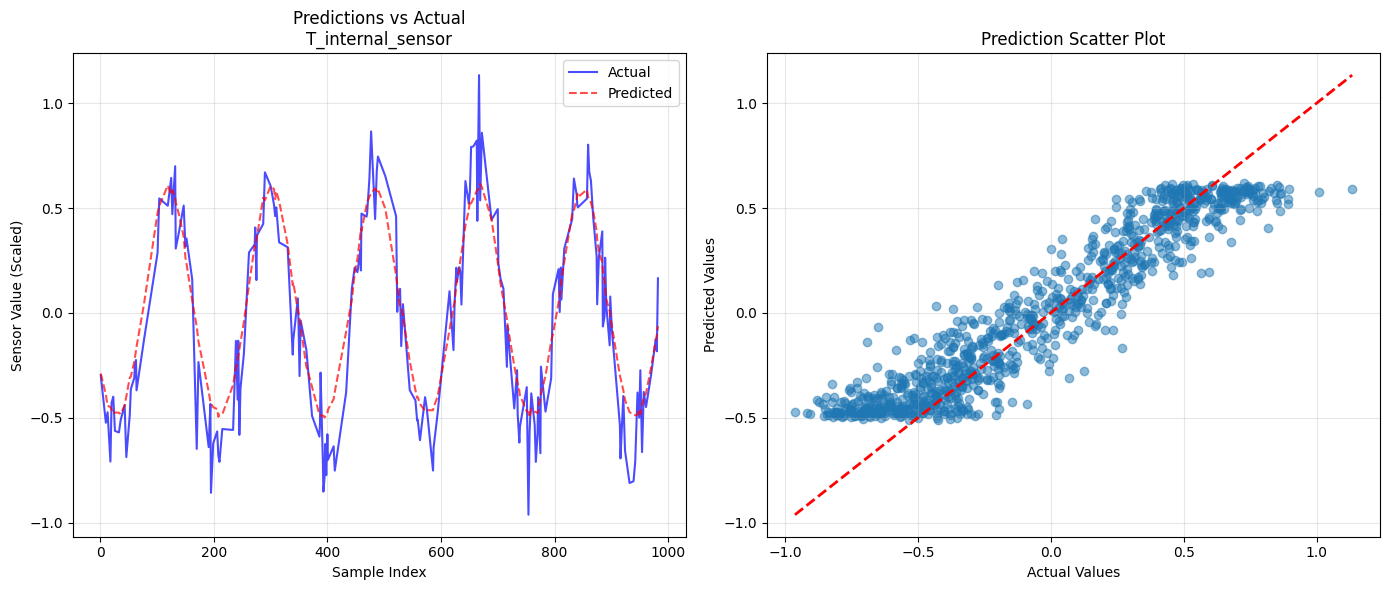

In [294]:
y_true_flat = np.array(y_true).reshape(-1)
y_pred_flat = np.array(y_pred).reshape(-1)

plt.figure(figsize=(14, 6))

# Sample a subset for visualization if too many points
num_samples = min(200, len(y_true_flat))
if num_samples == 0:
    print("No test samples available to plot.")
else:
    indices = np.random.choice(len(y_true_flat), num_samples, replace=False)
    indices = np.sort(indices)

    plt.subplot(1, 2, 1)
    plt.plot(indices, y_true_flat[indices], 'b-', label='Actual', alpha=0.7)
    plt.plot(indices, y_pred_flat[indices], 'r--', label='Predicted', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value (Scaled)')
    plt.title(f'Predictions vs Actual\n{sensor_features[select_model]}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.5)
    mn = min(y_true_flat.min(), y_pred_flat.min())
    mx = max(y_true_flat.max(), y_pred_flat.max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction Scatter Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Pruning the Model

In [28]:
!pip install tf-keras

In [29]:
import tf_keras
import tempfile

In [30]:
# Configure pruning parameters using tf_keras
from tf_keras.mixed_precision import set_global_policy

# Create a pruned version of the model with reduced complexity
def create_pruned_cnn_model(seq_length, forecast_horizon):
    """
    Create a CNN model with structured pruning by reducing layer dimensions.
    This approach achieves pruning through architectural changes rather than weight masking.
    """
    model = tf_keras.Sequential([
        tf_keras.layers.Input(shape=(seq_length, 1)),
        tf_keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='valid'),  # Reduced from 64
        tf_keras.layers.Dropout(0.25),
        tf_keras.layers.MaxPooling1D(pool_size=2),
        tf_keras.layers.Flatten(),
        tf_keras.layers.Dense(25, activation='relu'),  # Reduced from 50 (50% pruning)
        tf_keras.layers.Dropout(0.25),
        tf_keras.layers.Dense(forecast_horizon)
    ])
    
    return model

# Build the pruned model
pruned_model = create_pruned_cnn_model(X_train.shape[1], FORECAST_HORIZON)

# Compile the pruned model
pruned_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

pruned_model.summary()
print("\n--- Pruned Model Created (50% smaller architecture) ---")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 164, 32)           192       
                                                                 
 dropout (Dropout)           (None, 164, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 82, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2624)              0         
                                                                 
 dense (Dense)               (None, 25)                65625     
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                        

In [32]:
# Train the pruned model
print("\n--- Training Pruned Model ---")

# Use tf_keras callbacks for compatibility with tf_keras model
early_stopping_pruned = tf_keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_pruned = tf_keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks_pruned = [early_stopping_pruned, reduce_lr_pruned]

# Train the pruned model
history_pruned = pruned_model.fit(
    X_train_feature,
    Y_train_feature,
    validation_data=(X_val_feature, Y_val_feature),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_pruned,
    verbose=1
)

print("\n--- Pruned Model Training Complete ---")


--- Training Pruned Model ---
Epoch 1/10
93/93 [==============================] - 1s 4ms/step - loss: 0.0550 - mae: 0.1766 - val_loss: 0.0427 - val_mae: 0.1675 - lr: 0.0010
Epoch 2/10
93/93 [==============================] - 1s 4ms/step - loss: 0.0550 - mae: 0.1766 - val_loss: 0.0427 - val_mae: 0.1675 - lr: 0.0010
Epoch 2/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0386 - mae: 0.1551 - val_loss: 0.0371 - val_mae: 0.1520 - lr: 0.0010
Epoch 3/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0386 - mae: 0.1551 - val_loss: 0.0371 - val_mae: 0.1520 - lr: 0.0010
Epoch 3/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0396 - mae: 0.1545 - val_loss: 0.0308 - val_mae: 0.1336 - lr: 0.0010
Epoch 4/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0396 - mae: 0.1545 - val_loss: 0.0308 - val_mae: 0.1336 - lr: 0.0010
Epoch 4/10
93/93 [==============================] - 0s 3ms/step - loss: 0.0404 - mae: 0.1552 - val_loss: 0.0314

In [33]:
# Evaluate the pruned model
print("\n--- Evaluating Pruned Model Performance ---")
y_true_pruned, y_pred_pruned = evaluate_model(pruned_model, X_test_feature, Y_test_feature)

# Regression metrics for pruned model
mse_pruned = mean_squared_error(y_true_pruned.flatten(), y_pred_pruned.flatten())
mae_pruned = mean_absolute_error(y_true_pruned.flatten(), y_pred_pruned.flatten())
rmse_pruned = np.sqrt(mse_pruned)
r2_pruned = r2_score(y_true_pruned.flatten(), y_pred_pruned.flatten())

print("\nPruned Model Regression Metrics:")
print(f"Mean Squared Error (MSE): {mse_pruned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_pruned:.4f}")
print(f"Mean Absolute Error (MAE): {mae_pruned:.4f}")
print(f"R² Score: {r2_pruned:.4f}")

# Compare with original model
print("\n--- Comparison: Original vs Pruned Model ---")
print(f"Original MSE: {mse:.4f} | Pruned MSE: {mse_pruned:.4f} | Difference: {mse_pruned - mse:.4f}")
print(f"Original MAE: {mae:.4f} | Pruned MAE: {mae_pruned:.4f} | Difference: {mae_pruned - mae:.4f}")
print(f"Original R²: {r2:.4f} | Pruned R²: {r2_pruned:.4f} | Difference: {r2_pruned - r2:.4f}")


--- Evaluating Pruned Model Performance ---

Pruned Model Regression Metrics:
Mean Squared Error (MSE): 0.0291
Root Mean Squared Error (RMSE): 0.1706
Mean Absolute Error (MAE): 0.1351
R² Score: 0.8694

--- Comparison: Original vs Pruned Model ---
Original MSE: 0.0283 | Pruned MSE: 0.0291 | Difference: 0.0008
Original MAE: 0.1336 | Pruned MAE: 0.1351 | Difference: 0.0015
Original R²: 0.8730 | Pruned R²: 0.8694 | Difference: -0.0035


In [34]:
# The pruned model is already in its final form (no wrappers to strip)
final_pruned_model = pruned_model

print("\n--- Pruned Model Ready ---")
print("The model uses a 50% smaller architecture (structured pruning).")
final_pruned_model.summary()


--- Pruned Model Ready ---
The model uses a 50% smaller architecture (structured pruning).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 164, 32)           192       
                                                                 
 dropout (Dropout)           (None, 164, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 82, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2624)              0         
                                                                 
 dense (Dense)               (None, 25)                65625     
                                                                 
 dropout_1 (Dropout)         (

# Quantization (8-bit Integer)

In [35]:
# Save the pruned model temporarily for quantization
temp_model_path = tempfile.mktemp(suffix='.h5')
final_pruned_model.save(temp_model_path)
print(f"Pruned model saved temporarily at: {temp_model_path}")

# Create a representative dataset generator for quantization
def representative_dataset_gen():
    """
    Generator function to provide representative samples for quantization.
    Uses a subset of training data.
    """
    num_calibration_samples = min(100, len(X_train_feature))
    for i in range(num_calibration_samples):
        # Yield a single sample with correct shape for the model
        yield [X_train_feature[i:i+1].astype(np.float32)]

print("\nRepresentative dataset generator created for quantization.")

Pruned model saved temporarily at: /tmp/tmpgggi721i.h5

Representative dataset generator created for quantization.


/home/redninjale/AFTAC-DL/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# Convert the pruned model to TensorFlow Lite with 8-bit integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(final_pruned_model)

# Set optimization flags for full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

# Ensure all ops are quantized to int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

print("\n--- Converting to TFLite with 8-bit Quantization ---")
print("This may take a moment...")

try:
    quantized_tflite_model = converter.convert()
    print("✓ Quantization successful!")
except Exception as e:
    print(f"Full int8 quantization failed: {e}")
    print("\nTrying with dynamic range quantization instead...")
    # Fallback to dynamic range quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(final_pruned_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    quantized_tflite_model = converter.convert()
    print("✓ Dynamic range quantization successful!")

# Save the quantized model
quantized_model_path = './pruned_quantized_model.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

print(f"\n--- Quantized Model Saved ---")
print(f"Location: {quantized_model_path}")
print(f"Size: {len(quantized_tflite_model) / 1024:.2f} KB")


--- Converting to TFLite with 8-bit Quantization ---
This may take a moment...
INFO:tensorflow:Assets written to: /tmp/tmp9a4or32q/assets
INFO:tensorflow:Assets written to: /tmp/tmp9a4or32q/assets


INFO:tensorflow:Assets written to: /tmp/tmp9a4or32q/assets
/home/redninjale/AFTAC-DL/.venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/home/redninjale/AFTAC-DL/.venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✓ Quantization successful!

--- Quantized Model Saved ---
Location: ./pruned_quantized_model.tflite
Size: 69.42 KB


W0000 00:00:1763488623.890495    2443 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1763488623.890527    2443 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-18 11:57:03.890736: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9a4or32q
2025-11-18 11:57:03.891428: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-18 11:57:03.891434: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp9a4or32q
I0000 00:00:1763488623.896348    2443 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-11-18 11:57:03.896924: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-18 11:57:03.919438: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp9a4or32q
2025-11-18 11:57:03.924828: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [37]:
# Compare model sizes
import os

# Get original model size
original_model_path = tempfile.mktemp(suffix='.h5')
model.save(original_model_path)
original_size = os.path.getsize(original_model_path)

# Get pruned model size  
pruned_size = os.path.getsize(temp_model_path)

# Get quantized model size
quantized_size = len(quantized_tflite_model)

print("\n=== Model Size Comparison ===")
print(f"Original Model: {original_size / 1024:.2f} KB")
print(f"Pruned Model: {pruned_size / 1024:.2f} KB ({(1 - pruned_size/original_size)*100:.1f}% reduction)")
print(f"Pruned + Quantized Model: {quantized_size / 1024:.2f} KB ({(1 - quantized_size/original_size)*100:.1f}% reduction)")
print(f"\nTotal compression: {original_size / quantized_size:.2f}x smaller")

# Cleanup temporary files
os.remove(original_model_path)
os.remove(temp_model_path)


=== Model Size Comparison ===
Original Model: 3116.07 KB
Pruned Model: 809.55 KB (74.0% reduction)
Pruned + Quantized Model: 69.42 KB (97.8% reduction)

Total compression: 44.89x smaller


In [38]:
# Evaluate the quantized TFLite model
print("\n--- Evaluating Quantized Model ---")

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"Input details: {input_details[0]['shape']}, dtype: {input_details[0]['dtype']}")
print(f"Output details: {output_details[0]['shape']}, dtype: {output_details[0]['dtype']}")

# Make predictions on test set
quantized_predictions = []

for i in range(len(X_test_feature)):
    # Prepare input
    input_data = X_test_feature[i:i+1].astype(input_details[0]['dtype'])
    
    # If input is int8, we need to quantize
    if input_details[0]['dtype'] == np.int8:
        input_scale, input_zero_point = input_details[0]['quantization']
        input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # If output is int8, we need to dequantize
    if output_details[0]['dtype'] == np.int8:
        output_scale, output_zero_point = output_details[0]['quantization']
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
    
    quantized_predictions.append(output_data[0])

quantized_predictions = np.array(quantized_predictions)

# Calculate metrics
y_true_flat_quant = Y_test_feature.flatten()
y_pred_flat_quant = quantized_predictions.flatten()

mse_quantized = mean_squared_error(y_true_flat_quant, y_pred_flat_quant)
mae_quantized = mean_absolute_error(y_true_flat_quant, y_pred_flat_quant)
rmse_quantized = np.sqrt(mse_quantized)
r2_quantized = r2_score(y_true_flat_quant, y_pred_flat_quant)

print("\nQuantized Model Regression Metrics:")
print(f"Mean Squared Error (MSE): {mse_quantized:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_quantized:.4f}")
print(f"Mean Absolute Error (MAE): {mae_quantized:.4f}")
print(f"R² Score: {r2_quantized:.4f}")

print("\n=== Final Model Comparison ===")
print(f"{'Model':<25} {'MSE':<10} {'MAE':<10} {'R²':<10}")
print(f"{'-'*55}")
print(f"{'Original':<25} {mse:<10.4f} {mae:<10.4f} {r2:<10.4f}")
print(f"{'Pruned':<25} {mse_pruned:<10.4f} {mae_pruned:<10.4f} {r2_pruned:<10.4f}")
print(f"{'Pruned + Quantized':<25} {mse_quantized:<10.4f} {mae_quantized:<10.4f} {r2_quantized:<10.4f}")


--- Evaluating Quantized Model ---
Input details: [  1 168   1], dtype: <class 'numpy.int8'>
Output details: [1 1], dtype: <class 'numpy.int8'>

Quantized Model Regression Metrics:
Mean Squared Error (MSE): 0.0881
Root Mean Squared Error (RMSE): 0.2968
Mean Absolute Error (MAE): 0.2452
R² Score: 0.6048

=== Final Model Comparison ===
Model                     MSE        MAE        R²        
-------------------------------------------------------
Original                  0.0283     0.1336     0.8730    
Pruned                    0.0291     0.1351     0.8694    
Pruned + Quantized        0.0881     0.2452     0.6048    


/home/redninjale/AFTAC-DL/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


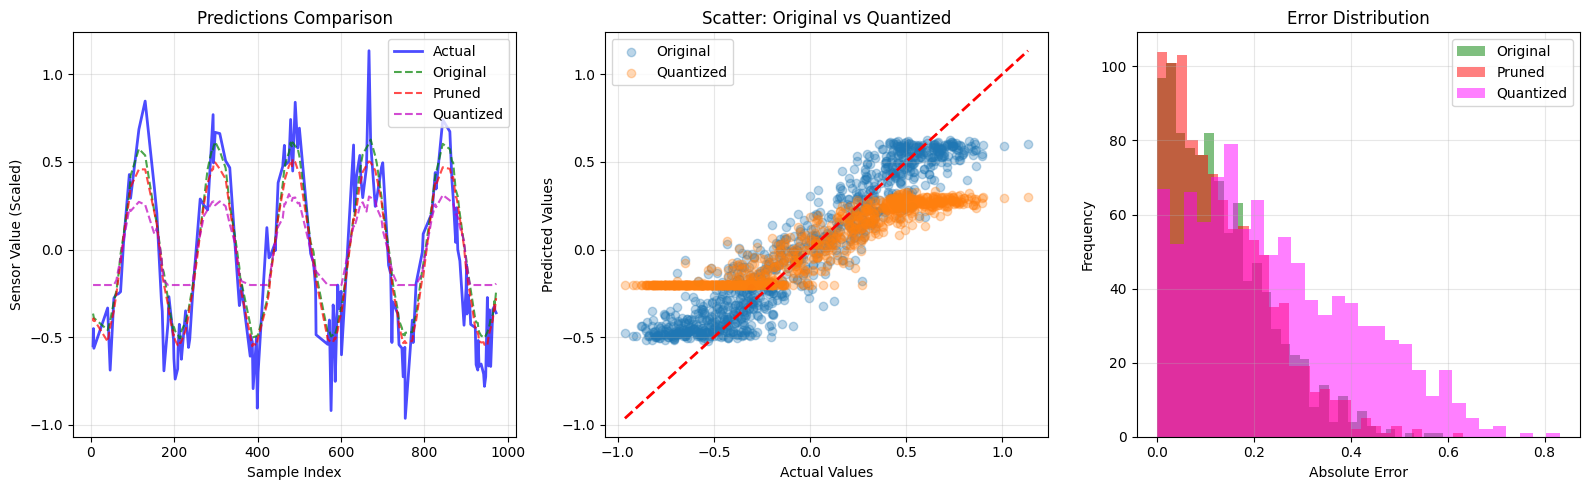

In [39]:
# Visualize predictions comparison
plt.figure(figsize=(16, 5))

num_samples = min(150, len(y_true_flat))
if num_samples > 0:
    indices = np.random.choice(len(y_true_flat), num_samples, replace=False)
    indices = np.sort(indices)

    # Plot 1: Time series comparison
    plt.subplot(1, 3, 1)
    plt.plot(indices, y_true_flat[indices], 'b-', label='Actual', alpha=0.7, linewidth=2)
    plt.plot(indices, y_pred_flat[indices], 'g--', label='Original', alpha=0.7)
    plt.plot(indices, y_pred_pruned.flatten()[indices], 'r--', label='Pruned', alpha=0.7)
    plt.plot(indices, y_pred_flat_quant[indices], 'm--', label='Quantized', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value (Scaled)')
    plt.title('Predictions Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Original vs Quantized scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, label='Original')
    plt.scatter(y_true_flat, y_pred_flat_quant, alpha=0.3, label='Quantized')
    mn = min(y_true_flat.min(), y_pred_flat.min(), y_pred_flat_quant.min())
    mx = max(y_true_flat.max(), y_pred_flat.max(), y_pred_flat_quant.max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter: Original vs Quantized')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Error distribution
    plt.subplot(1, 3, 3)
    error_original = np.abs(y_true_flat - y_pred_flat)
    error_pruned = np.abs(y_true_flat - y_pred_pruned.flatten())
    error_quantized = np.abs(y_true_flat - y_pred_flat_quant)
    
    plt.hist(error_original, bins=30, alpha=0.5, label='Original', color='green')
    plt.hist(error_pruned, bins=30, alpha=0.5, label='Pruned', color='red')
    plt.hist(error_quantized, bins=30, alpha=0.5, label='Quantized', color='magenta')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No test samples available to plot.")